In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import cv2
from sklearn import metrics
import threading as th
from tqdm import tqdm as progress_bar

import os

# input

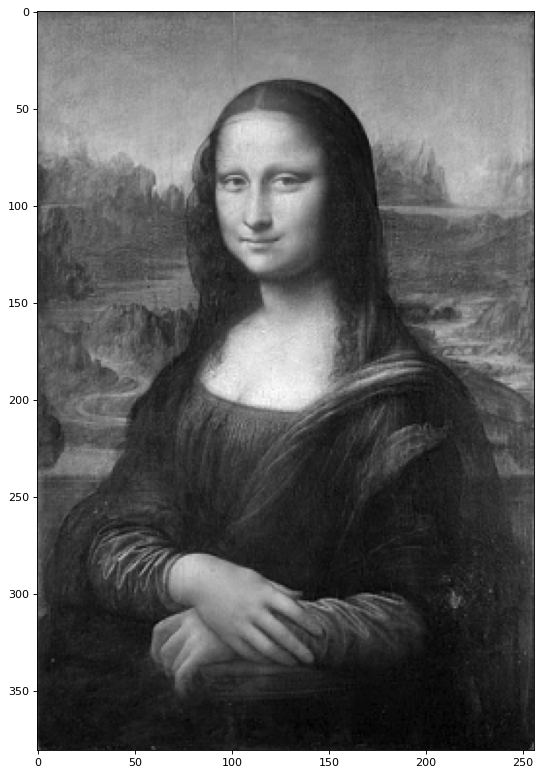

In [111]:
resize_to=256
#target_img=cv2.imread('./Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF.jpg')
target_img=cv2.imread('./input/mona.png')
#target_img=cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
target_img=cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)
#target_img=target_img[300:-400, 300:-300] # cut borders

hw_ratio=target_img.shape[0]/target_img.shape[1]
target_img=cv2.resize(target_img, (resize_to, int(hw_ratio*resize_to))) # widtxXheight
target_img=np.asarray(target_img)/255


figure(figsize=(16, 12), dpi=80)
plt.imshow(target_img, cmap='gray')
plt.show()

In [32]:
target_array=target_img.flatten()

In [47]:
target_img.shape

(381, 256)

In [48]:
with open('./input/mona_gray_cuda.txt', 'w') as file:
    file.write(str(target_array.tolist())[1:-1].replace(',',''))

In [103]:
img_x,img_y=target_img.shape

In [186]:
max_radius=np.sqrt(pow(target_img.shape[0],2)+pow(target_img.shape[1], 2))/2

In [257]:
def represent_individual(X, X_img=None):
    if isinstance(X_img, type(None)): 
        X_img=np.zeros(target_img.shape)
    for c in X:
        #[x, y, radius, opacity, r, g, b]
        x=int(c[0]*target_img.shape[0])
        y=int(c[1]*target_img.shape[1])
        radius=int(c[2]*max_radius)
        opacity=c[3]
        rgb=c[4:]
  #      print(x,y,radius)
        circle_img=cv2.rectangle(X_img.copy(), 
                                (y, x), # opencv takes arguments other way around thank cuda
                                (y+radius, x+radius), 
                                rgb,
                                thickness=-1)
        X_img=cv2.addWeighted(X_img, 1-opacity, circle_img, opacity, 0)
    return X_img

# output

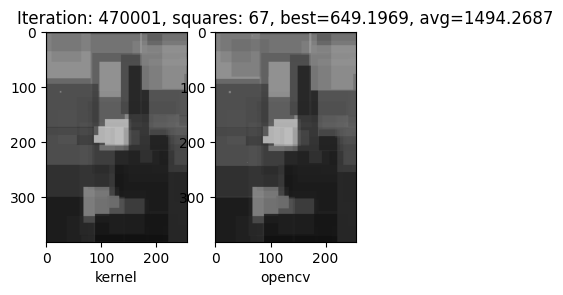

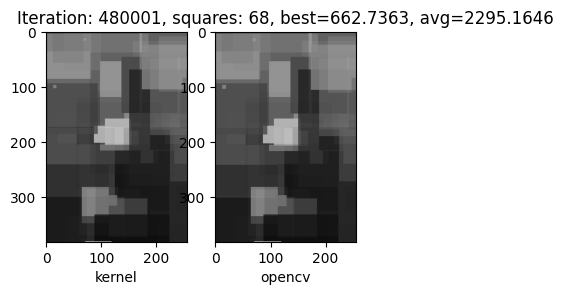

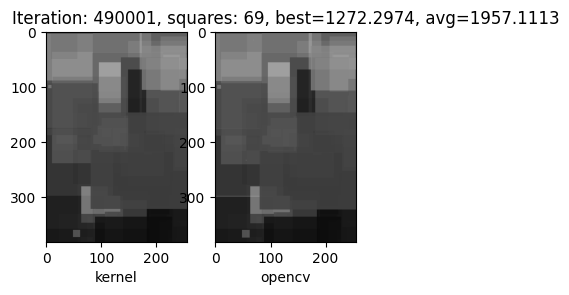

In [325]:
show_last=3


iter_imgs=[]
with open('./cuda_output/mona_results.txt', 'r') as file:
    for l in file.readlines()[-show_last:]:
        l=l.strip()
        if l:
            iter_imgs.append([float(x) for x in  l.split(',')[:-1]]) 

iter_mates=[]
with open('./cuda_output/mona_mates.txt', 'r') as file:
    for l in file.readlines()[-show_last:]:
        l=l.strip()
        if l:
            iter_mates.append([float(x) for x in  l.split(',')[:-1]]) 

for mate, mate_img in zip(iter_mates, iter_imgs):
  #  iter, no_squares, best_mse, avg_mse
    iter=int(mate[0])
    limit=int(mate[1])
    best=mate[2]
    avg=mate[3]
    img_kernel=np.array(mate_img[1:]).reshape(img_x, img_y)
    mate_chromosome=np.asarray(mate[4:4+5*limit]).reshape(limit,5)
    img_cv=represent_individual(mate_chromosome)

    fig, axs = plt.subplots(1, 2, figsize=(4,6))
    axs[0].imshow(img_kernel, cmap='gray',vmin=0, vmax=1)
    axs[0].set_xlabel('kernel')
    axs[1].imshow(img_cv, cmap='gray',vmin=0, vmax=1)
    axs[1].set_xlabel('opencv')


    plt.title(f'Iteration: {iter}, squares: {limit}, best={best:.4f}, avg={avg:.4f}')
    plt.show()